# Анализ развлекательного приложения Procrastinate Pro+

**Проблема**: Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. 

**Цель исследования**:
Разобраться в причинах и помочь компании выйти в плюс.

**Ход исследования**

Данные были получены 
- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

**Информация о входных данных**

Предоставлены данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
лог сервера с данными об их посещениях, выгрузка их покупок за этот период, рекламные расходы.

Файл visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, orders_info_short.csv — информацию о заказах, а costs_info_short.csv — информацию о расходах на рекламу.

Структура visits_info_short.csv:
* __``User Id ``__ — уникальный идентификатор пользователя
* __``Region``__ — страна пользователя
* __``Device``__ — тип устройства пользователя
* __``Channel``__ — идентификатор источника перехода
* __``Session Start``__ — дата и время начала сессии
* __``Session End``__ — дата и время окончания сессии

Структура orders_info_short.csv:

* __``User Id``__ — уникальный идентификатор пользователя
* __``Event Dt ``__ — дата и время покупки
* __``Revenue``__ — сумма заказа

Структура costs_info_short.csv:
* __``dt``__ — дата проведения рекламной кампании
* __``Channel``__ — идентификатор рекламного источника
* __``costs``__ — расходы на эту кампанию

Исследование пройдёт в три этапа:
 1. Обзор данных.
 2. Предобработка данных.
 3. Анализ данных:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

## 1. Загрузка и предобработка данных

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale = 1.2)
sns.set_palette(sns.color_palette('Paired'))

import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    visits = pd.read_csv('data/project_6/visits_info_short.csv')
except:
    visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv')
    
try:
    orders = pd.read_csv('data/project_6/orders_info_short.csv')
except:
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv')

try:
    costs = pd.read_csv('data/project_6/costs_info_short.csv')
except:
    costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv')

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
visits.sample(10)

,User Id,Region,Device,Channel,Session Start,Session End
118896,984593133117,United States,iPhone,RocketSuperAds,2019-08-23 15:25:30,2019-08-23 16:08:18
264506,55303129847,Germany,Android,organic,2019-08-19 10:08:47,2019-08-19 10:17:18
74594,512566276165,United States,Android,organic,2019-07-13 16:30:38,2019-07-13 16:52:59
117247,642925618125,United States,iPhone,organic,2019-08-21 16:23:17,2019-08-21 16:27:55
48382,726033186473,United States,Mac,organic,2019-06-21 21:43:49,2019-06-21 22:00:47
152119,427095436009,United States,Android,RocketSuperAds,2019-09-20 10:54:26,2019-09-20 10:54:54
251770,868135863393,Germany,PC,AdNonSense,2019-07-29 16:51:04,2019-07-29 17:11:15
253871,780287645788,France,Mac,AdNonSense,2019-08-02 22:55:53,2019-08-02 23:11:06
70471,20640788170,United States,iPhone,TipTop,2019-07-09 18:05:54,2019-07-09 18:24:43
90282,162122420677,United States,Mac,organic,2019-07-30 14:33:25,2019-07-30 14:57:30


In [5]:
visits.duplicated().sum()

0

In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [7]:
orders.sample(10)

,User Id,Event Dt,Revenue
14581,299446319938,2019-08-27 10:42:49,4.99
21216,324183131293,2019-09-30 09:36:12,4.99
13632,249736235628,2019-08-21 10:23:02,4.99
6441,796083483287,2019-07-06 00:44:51,4.99
35941,534569424552,2019-09-18 14:25:32,4.99
31352,398297234309,2019-07-19 13:35:48,4.99
15783,46668935978,2019-09-02 22:34:40,4.99
6403,228097129317,2019-07-06 13:04:03,4.99
24760,705441785280,2019-10-17 13:15:13,4.99
10849,202770285245,2019-08-04 01:55:41,4.99


In [8]:
orders.duplicated().sum()

0

In [9]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [10]:
costs.sample(10)

,dt,Channel,costs
310,2019-09-08,MediaTornado,4.08
840,2019-08-29,YRabbit,3.78
1723,2019-08-12,lambdaMediaAds,6.40
450,2019-07-30,RocketSuperAds,7.28
161,2019-10-09,FaceBoom,172.70
1719,2019-08-08,lambdaMediaAds,4.00
1294,2019-06-04,OppleCreativeMedia,9.00
211,2019-06-01,MediaTornado,4.32
701,2019-10-09,TipTop,381.50
526,2019-10-14,RocketSuperAds,6.50


In [11]:
costs.duplicated().sum()

0

<div style="border:solid lightgreen 2px; padding: 20px">
<div class="alert alert-block alert-info">
<font color='Black'>
В датафреймах отсутствуют пропуски и явные дубликаты, требуется переименование ряда столбцов и приведение столбцов, содержащих информацию о дате к соответствующему формату.
    
</font>  
</div>    
</div>

In [12]:
visits.rename(columns={'User Id':'user_id', 'Region':'region', 'Device':'device', 'Channel':'channel', 'Session Start':'session_start', 'Session End':'session_end'}, inplace=True)

In [13]:
orders.rename(columns={'User Id':'user_id', 'Event Dt':'event_dt', 'Revenue':'revenue'}, inplace=True)

In [14]:
costs.rename(columns={'Channel': 'channel'}, inplace=True)

In [15]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

## 2. Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

Функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [16]:
# функция для создания пользовательских профилей
def get_profiles(sessions, orders, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [17]:
# функция для расчёта удержания
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [18]:
# функция для расчёта конверсии
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [19]:
# функция для расчёта LTV и ROI
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [20]:
# функция для сглаживания фрейма
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [21]:
# функция для визуализации удержания
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [22]:
# функция для визуализации конверсии
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [23]:
# функция для визуализации LTV и ROI
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## 3. Исследовательский анализ данных

Профили пользователей. Определение минимальной и максимальной даты привлечения пользователей.

In [24]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [25]:
# минимальная дата привлечения пользователей
profiles.sort_values(by='first_ts')['first_ts'].head(1)

57600   2019-05-01 00:00:41
Name: first_ts, dtype: datetime64[ns]

In [26]:
# максимальная дата привлечения пользователей
profiles.sort_values(by='first_ts', ascending = False)['first_ts'].head(1)

111023   2019-10-27 23:59:04
Name: first_ts, dtype: datetime64[ns]

Из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей.

In [27]:
# проверим, покупал ли посетитель что-то больше одного раза
profiles['user_id'].duplicated().sum()

0

In [28]:
region = profiles.groupby('region').agg({'user_id':'nunique'}).sort_values(by = 'user_id', ascending = False).reset_index()

In [29]:
region

,region,user_id
0,United States,100002
1,UK,17575
2,France,17450
3,Germany,14981


In [30]:
payers = profiles.query('payer == True')
payers = payers.groupby('region')['payer'].count().sort_values(ascending = False).reset_index()

In [31]:
payers

,region,payer
0,United States,6902
1,UK,700
2,France,663
3,Germany,616


In [32]:
region = pd.merge(region, payers, on='region')

In [33]:
# Расчет доли платящих в конкретной стране
region['share_%'] = region['payer'] / region['user_id'] * 100

In [34]:
region = region.drop(['payer'], axis=1).sort_values(by='share_%', ascending = False)

In [35]:
region

,region,user_id,share_%
0,United States,100002,6.901862
3,Germany,14981,4.111875
1,UK,17575,3.982930
2,France,17450,3.799427


<div style="border:solid lightgreen 2px; padding: 20px">
<div class="alert alert-block alert-info">
<font color='Black'>
Пользователи приходят в приложение из США, Великобритании, Франции и Германии. Больше всего платящих пользователей приходит из США (<b>6.9%</b>).
</font>  
</div>    
</div>

Какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи.

In [36]:
device = profiles.groupby(['device']).agg({'user_id':'nunique'}).sort_values(by = 'user_id', ascending = False).reset_index()

In [37]:
device

,device,user_id
0,iPhone,54479
1,Android,35032
2,PC,30455
3,Mac,30042


In [38]:
payers = profiles.query('payer == True')
payers = payers.groupby('device')['payer'].count().sort_values(ascending = False).reset_index()

In [39]:
payers

,device,payer
0,iPhone,3382
1,Android,2050
2,Mac,1912
3,PC,1537


In [40]:
device = pd.merge(device, payers, on='device')

In [41]:
device['share_%'] = device['payer'] / device['user_id'] * 100

In [42]:
device = device.drop(['payer'], axis=1).sort_values(by='share_%', ascending = False)

In [43]:
device

,device,user_id,share_%
3,Mac,30042,6.364423
0,iPhone,54479,6.207897
1,Android,35032,5.851793
2,PC,30455,5.046790


<div style="border:solid lightgreen 2px; padding: 20px">
<div class="alert alert-block alert-info">
<font color='Black'>
Пользователи использую следующие устройства: iPhone, Android, PC, Mac. Больше всего платящих пользователей использует Mac и iPhone (<b>6.36% и 6.2%</b>).
</font>  
</div>    
</div>

Рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей.

In [44]:
channel = profiles.groupby(['channel']).agg({'user_id':'nunique'}).sort_values(by = 'user_id', ascending = False).reset_index()

In [45]:
channel

,channel,user_id
0,organic,56439
1,FaceBoom,29144
2,TipTop,19561
3,OppleCreativeMedia,8605
4,LeapBob,8553
5,WahooNetBanner,8553
6,RocketSuperAds,4448
7,MediaTornado,4364
8,YRabbit,4312
9,AdNonSense,3880


In [46]:
payers = profiles.query('payer == True')
payers = payers.groupby('channel')['payer'].count().sort_values(ascending = False).reset_index()

In [47]:
payers

,channel,payer
0,FaceBoom,3557
1,TipTop,1878
2,organic,1160
3,WahooNetBanner,453
4,AdNonSense,440
5,RocketSuperAds,352
6,LeapBob,262
7,OppleCreativeMedia,233
8,lambdaMediaAds,225
9,YRabbit,165


In [48]:
channel = pd.merge(channel, payers, on='channel').sort_values(by='payer', ascending = False)

In [49]:
channel

,channel,user_id,payer
1,FaceBoom,29144,3557
2,TipTop,19561,1878
0,organic,56439,1160
5,WahooNetBanner,8553,453
9,AdNonSense,3880,440
6,RocketSuperAds,4448,352
4,LeapBob,8553,262
3,OppleCreativeMedia,8605,233
10,lambdaMediaAds,2149,225
8,YRabbit,4312,165


In [50]:
channel['share_%'] = channel['payer'] / channel['user_id'] * 100

In [51]:
channel = channel.drop(['payer'], axis=1).sort_values(by='share_%', ascending = False)

In [52]:
channel

,channel,user_id,share_%
1,FaceBoom,29144,12.204914
9,AdNonSense,3880,11.340206
10,lambdaMediaAds,2149,10.469986
2,TipTop,19561,9.600736
6,RocketSuperAds,4448,7.913669
5,WahooNetBanner,8553,5.296387
8,YRabbit,4312,3.826531
7,MediaTornado,4364,3.574702
4,LeapBob,8553,3.063253
3,OppleCreativeMedia,8605,2.707728


<div style="border:solid lightgreen 2px; padding: 20px">
<div class="alert alert-block alert-info">
<font color='Black'>
Больше всего платящих пользователей пришло из FaceBoom, AdNonSense и lambdaMediaAds (<b>12.2%, 11.34% и 10.46%</b>).
</font>  
</div>    
</div>

## 4. Маркетинг

Общая сумма расходов на маркетинг

In [53]:
# Предположим, что компания не платит за SEO и органическая выдача не является платным каналом привлечения
marketing_costs = profiles.query('channel != "organic"')

In [54]:
org = profiles.query('channel == "organic"')

In [55]:
org.acquisition_cost.value_counts()

0.0    56439
Name: acquisition_cost, dtype: int64

In [56]:
print('Общая сумма расходов на маркетинг: ' + str(marketing_costs.acquisition_cost.sum()))

Общая сумма расходов на маркетинг: 105497.3


<div style="border:solid lightgreen 2px; padding: 20px">
<div class="alert alert-block alert-info">
<font color='Black'>
    Общая сумма расходов на маркетинг составила: <b>105497.3</b>
</font>  
</div>    
</div>

Распределение трат по рекламным каналам

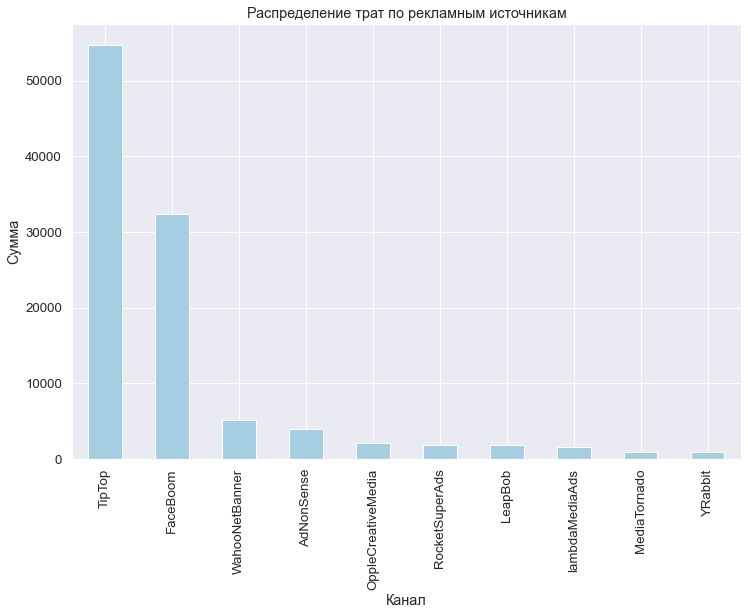

In [57]:
(
marketing_costs.groupby('channel')
    .agg({'acquisition_cost': 'sum'})
    .sort_values(by='acquisition_cost', ascending = False)
    .plot(kind='bar', legend=None)  
)    
plt.ylabel('Сумма')
plt.xlabel('Канал')
plt.title('Распределение трат по рекламным источникам'); 

In [58]:
marketing_costs.groupby('channel').agg({'acquisition_cost': 'sum'}).sort_values(by='acquisition_cost', ascending = False).reset_index()

,channel,acquisition_cost
0,TipTop,54751.30
1,FaceBoom,32445.60
2,WahooNetBanner,5151.00
3,AdNonSense,3911.25
4,OppleCreativeMedia,2151.25
5,RocketSuperAds,1833.00
6,LeapBob,1797.60
7,lambdaMediaAds,1557.60
8,MediaTornado,954.48
9,YRabbit,944.22


<div style="border:solid lightgreen 2px; padding: 20px">
<div class="alert alert-block alert-info">
<font color='Black'>
В анализируетый период времени компания использовала много каналов привлечения пользователей, однако больше всего средств было потрачено на <b>TipTop</b> и <b>FaceBoom</b>.
</font>  
</div>    
</div>

Визуализация динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.

In [59]:
costs['dt'] = pd.to_datetime(costs['dt'])

In [60]:
costs['week'] = costs['dt'].dt.isocalendar().week

In [61]:
costs['month'] = pd.to_datetime(costs['dt']).dt.month

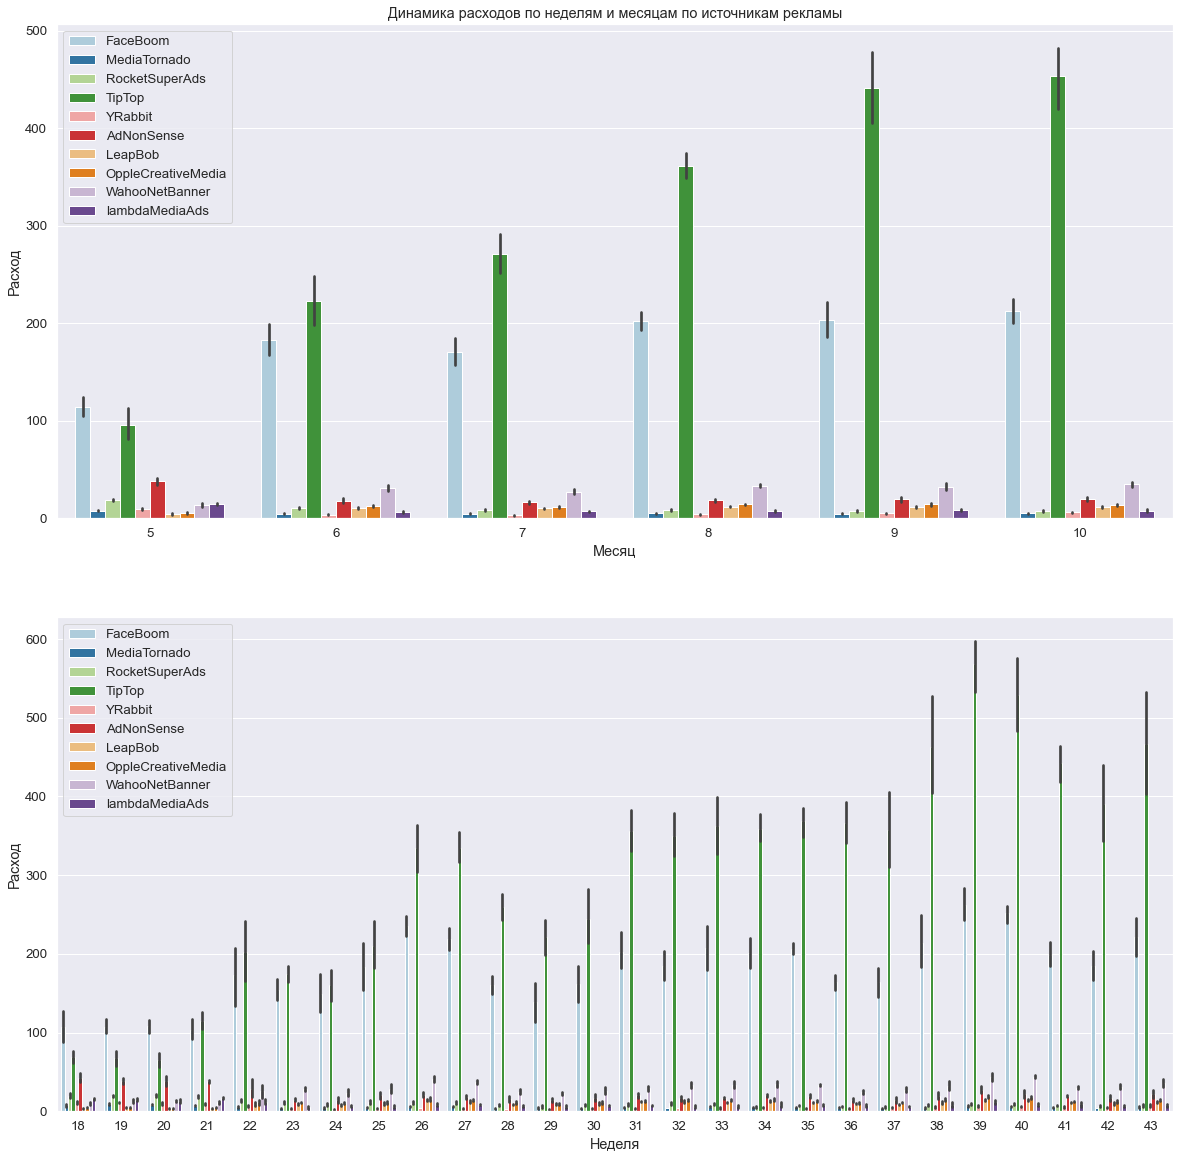

In [62]:
plt.figure(figsize=(20, 20))

ax1 = plt.subplot(2, 1, 1)
sns.barplot(data = costs, x='month',y='costs',hue='channel', ax=ax1)
plt.legend()
plt.xlabel('Месяц')
plt.ylabel('Расход')
plt.title('Динамика расходов по неделям и месяцам по источникам рекламы')

ax2 = plt.subplot(2, 1, 2)
sns.barplot(data = costs, x='week', y='costs', hue='channel', ax=ax2)
plt.legend()
plt.xlabel('Неделя')
plt.ylabel('Расход')
plt.show()

<div style="border:solid lightgreen 2px; padding: 20px">
<div class="alert alert-block alert-info">
<font color='Black'>
Исходя из графиков, представленных выше, видно, что расходы на TipTop увеличивались планомерно в течение всего года. Расходы на прочие каналы практически не менялись месяц от месяца. Понедельный график показывает волнообразное изменение расходов на привлечение клиентов.
</font>  
</div>    
</div>

Cредняя стоимость привлечение одного пользователя (CAC) из каждого источника.

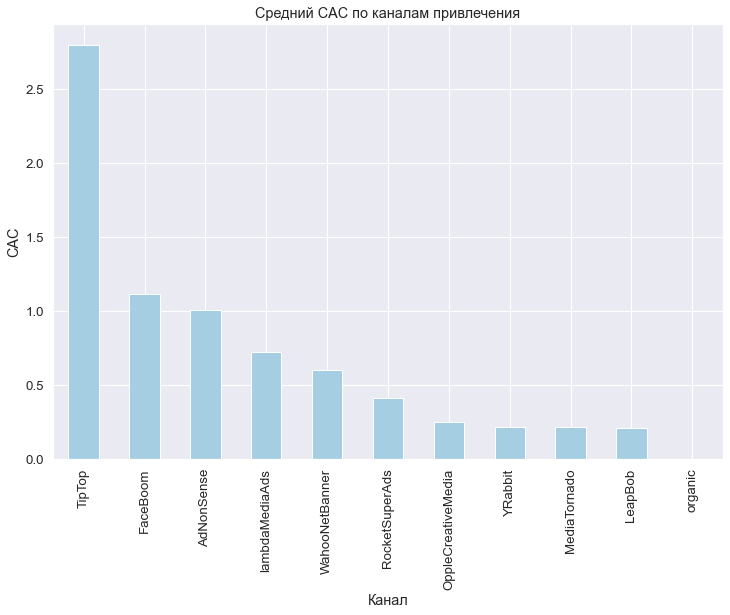

In [63]:
# считаем средний CAC по каналам привлечения
cac = (
    profiles.groupby('channel')
    .agg({'acquisition_cost': 'mean'})
    .rename(columns={'acquisition_cost': 'cac'})
    .sort_values(by='cac', ascending = False)
    .plot(kind = 'bar', legend = False)
    )
plt.xlabel('Канал') 
plt.ylabel('CAC') 
plt.title('Средний CAC по каналам привлечения');
plt.show()

In [64]:
cac = (
    profiles.groupby('channel')
    .agg({'acquisition_cost': 'mean'})
    .rename(columns={'acquisition_cost': 'cac'})
    .sort_values(by='cac', ascending = False)
)
cac.reset_index()

,channel,cac
0,TipTop,2.799003
1,FaceBoom,1.113286
2,AdNonSense,1.008054
3,lambdaMediaAds,0.724802
4,WahooNetBanner,0.602245
5,RocketSuperAds,0.412095
6,OppleCreativeMedia,0.250000
7,YRabbit,0.218975
8,MediaTornado,0.218717
9,LeapBob,0.210172


<div style="border:solid lightgreen 2px; padding: 20px">
<div class="alert alert-block alert-info">
<font color='Black'>
Средняя стоимость привлечения практически отражает распределение общих трат на привлечение (чем больше средств было потрачено на на канал, тем выше стоимость привлечения клиента). Выше всего САС у каналов TipTop и FaceBoom.
</font>  
</div>    
</div>

## 5. Оцените окупаемость рекламы

In [65]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

Анализ окупаемости рекламы c помощью графиков LTV и ROI

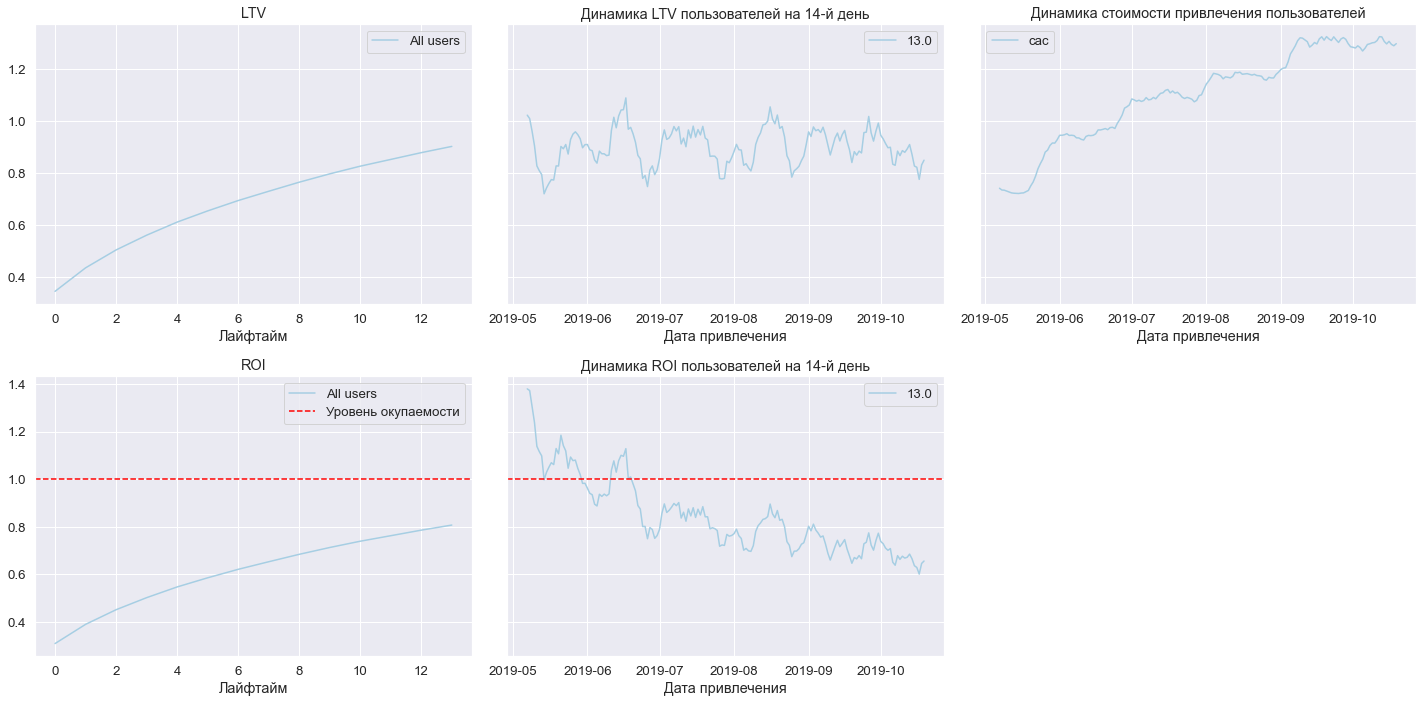

In [66]:
# считаем LTV и ROI, профили взяты без органической выдачи, тк стоимость привлечения нулевая
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    marketing_costs, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

<div style="border:solid lightgreen 2px; padding: 20px">
<div class="alert alert-block alert-info">
<font color='Black'>
    <ul><b>Выводы:</b>
    <li> Реклама не окупается, ROI к концу 2 недели незначительно выше 80%.</li>
    <li> CAC имеет тренд на увеличение.</li>
    <li> LTV имеет стабильный тренд, таким образом нельзя говорить о сезонности.</li>
    <li> Вероятно причина в ухудшении качества пользователей.</li>
    </ul>
</font>  
</div>    
</div>

Анализ конверсии пользователей и динамики её изменения

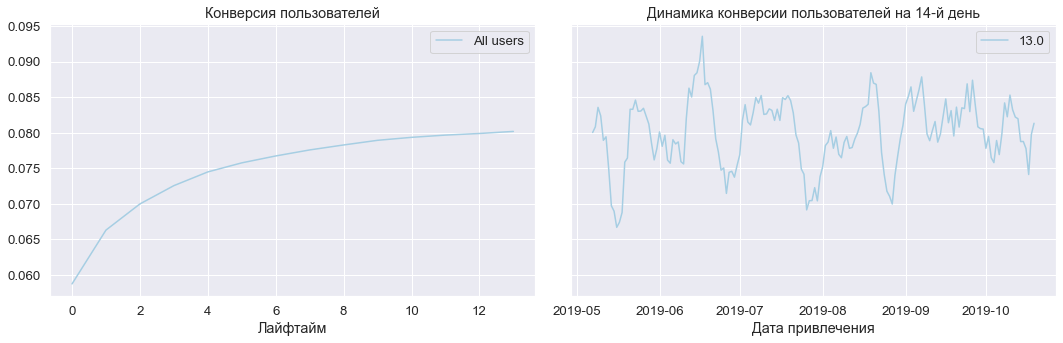

In [67]:
# смотрим конверсию
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    marketing_costs, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

<div style="border:solid lightgreen 2px; padding: 20px">
<div class="alert alert-block alert-info">
<font color='Black'>
    <ul><b>Выводы:</b>
Наблюдается устойчивая, но не высокая конверсия среди посетителей. Так же наблюдается сезонность.
    </ul>
</font>  
</div>    
</div>

Анализ удержания пользователей

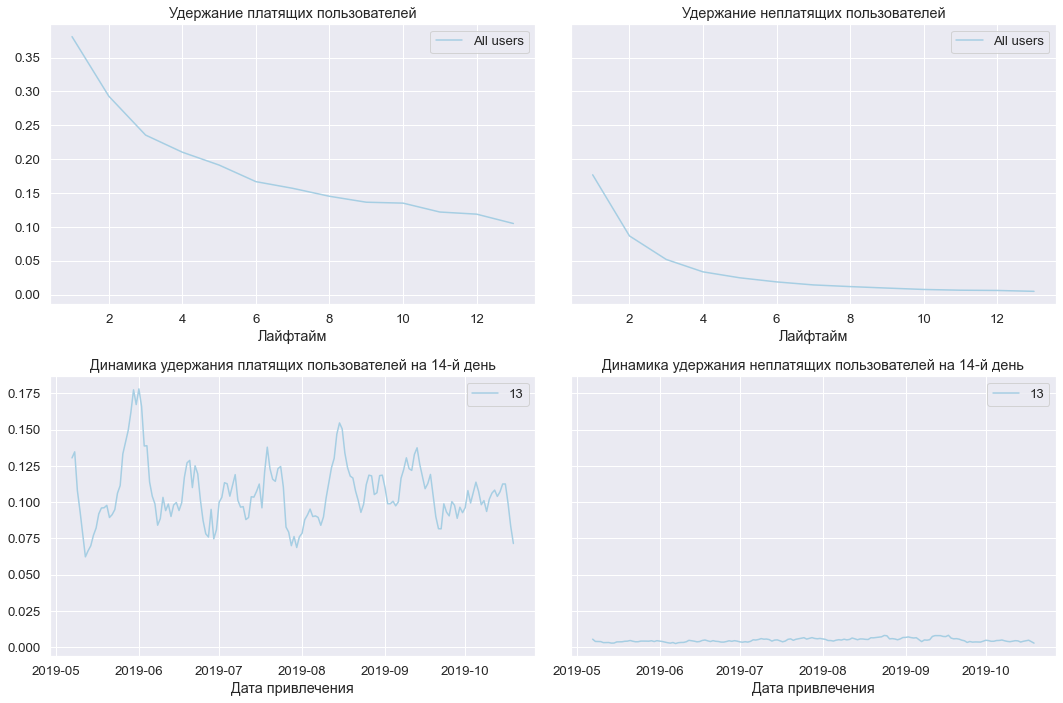

In [68]:
# смотрим удержание
retention_raw, retention_grouped, retention_history = get_retention(
    marketing_costs, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 

<div style="border:solid lightgreen 2px; padding: 20px">
<div class="alert alert-block alert-info">
<font color='Black'>
    <ul><b>Выводы:</b>
    <li> Удержание платящих посетителей на крайне низком уровне.</li>
    <li> Удержание неплатящих посетителей еще хуже, чем у платящих.</li>
    </ul>
</font>  
</div>    
</div>

Анализ окупаемости рекламы с разбивкой по устройствам

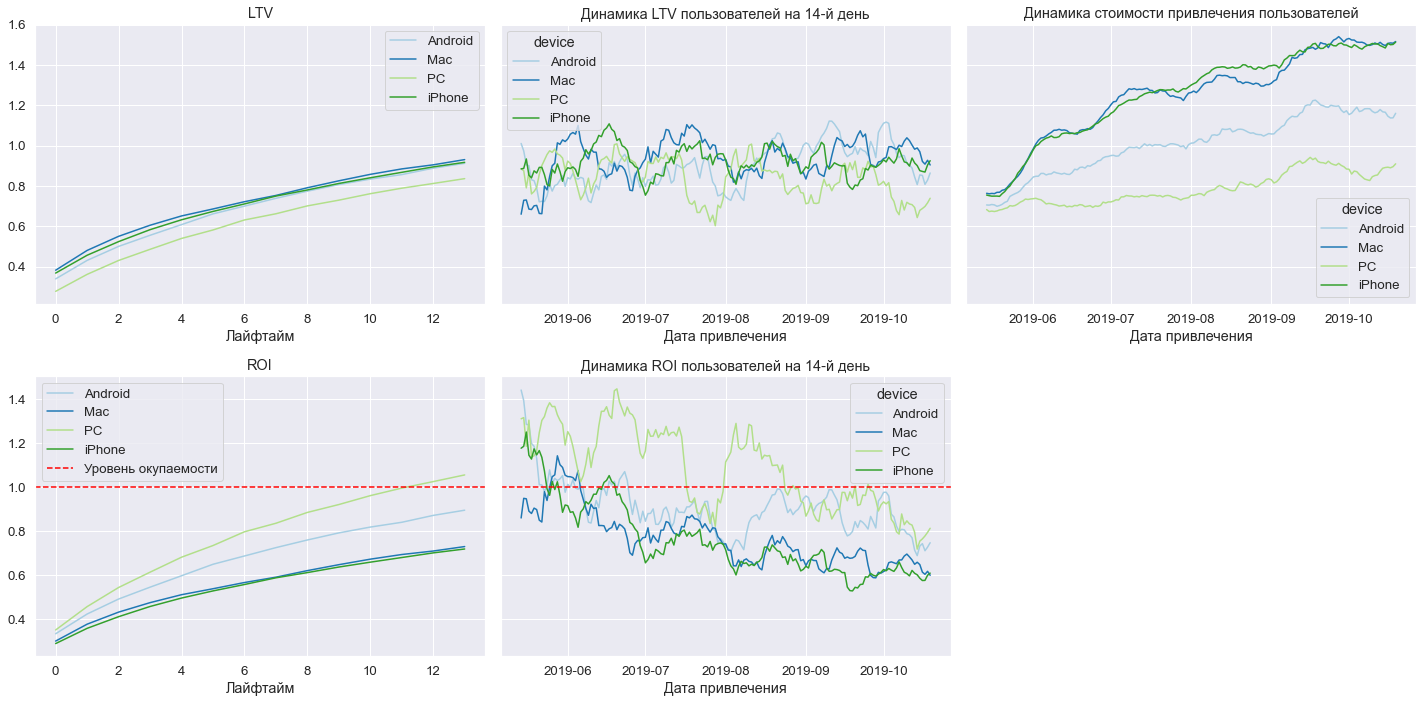

In [69]:
# смотрим окупаемость с разбивкой по устройствам
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    marketing_costs, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

<div style="border:solid lightgreen 2px; padding: 20px">
<div class="alert alert-block alert-info">
<font color='Black'>
    <ul><b>Выводы:</b>
    <li>Уровня окупаемости смогли достичь только устройсва PC.</li> 
    <li>Возможной причиной является относительно низкая стоимость привлечения пользователей по сравнению с другими платформами.</li>
    </ul>
</font>  
</div>    
</div>

Анализ конверсии рекламы с разбивкой по устройствам

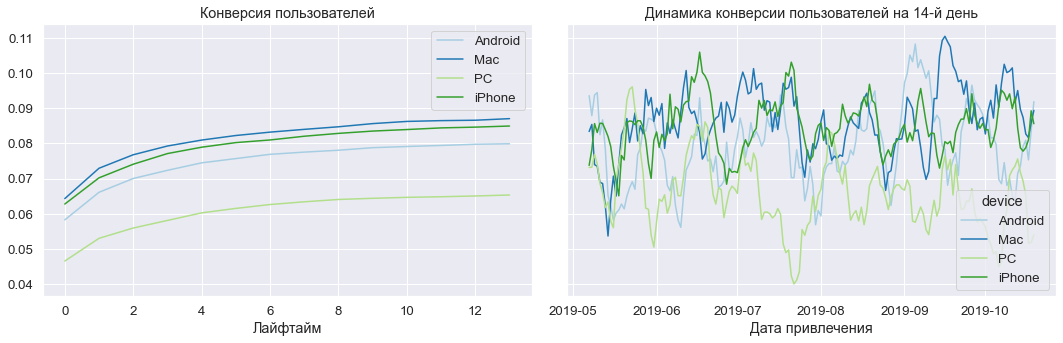

In [70]:
# смотрим конверсию с разбивкой по странам
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    marketing_costs, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

<div style="border:solid lightgreen 2px; padding: 20px">
<div class="alert alert-block alert-info">
<font color='Black'>
    <ul><b>Выводы:</b>
В целом конверсия очень низкая. Конверсия устройств Mac и iPhone выше, чем у прочих. Конверсия PC минимальна. Так же наблюдается некоторая сезонность.
    </ul>
</font>  
</div>    
</div>

Анализ удержания с разбивкой по устройствам

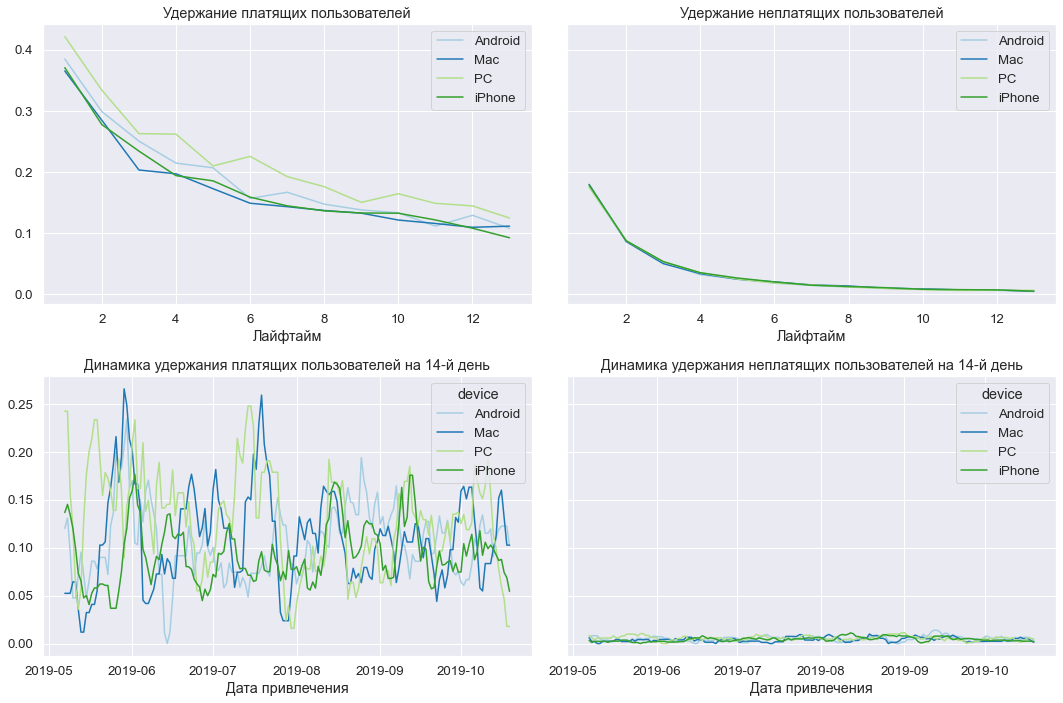

In [71]:
# смотрим удержание
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    marketing_costs, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

<div style="border:solid lightgreen 2px; padding: 20px">
<div class="alert alert-block alert-info">
<font color='Black'>
    <ul><b>Выводы:</b>
Удержание по устройствам находится приблизительно на одном уровне.
    </ul>
</font>  
</div>    
</div>

Анализ окупаемости рекламы с разбивкой по странам

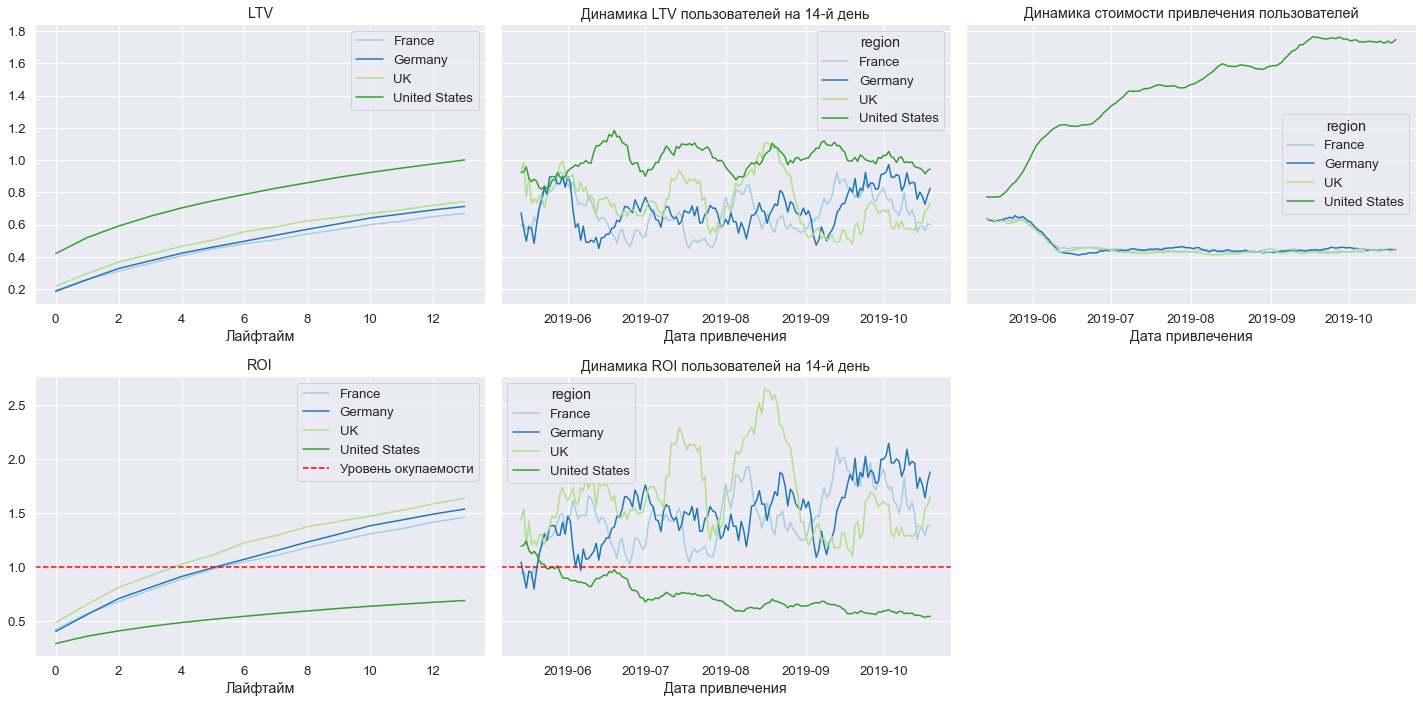

In [72]:
# смотрим окупаемость с разбивкой по странам
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    marketing_costs, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

<div style="border:solid lightgreen 2px; padding: 20px">
<div class="alert alert-block alert-info">
<font color='Black'>
    <ul><b>Выводы:</b>
    <li>Уровня окупаемости смогли достичь Франция, Германия и Великобритания.</li> 
    <li>В США больше всего используются платные методы привлечения клиентов, поэтому стоимость их привлечения существенно выше, чем в других странах.</li>
    <li>В тоже время LTV в США выше чем в прочих странах.</li>    
    </ul>
</font>  
</div>    
</div>

Анализ конверсии рекламы с разбивкой по странам

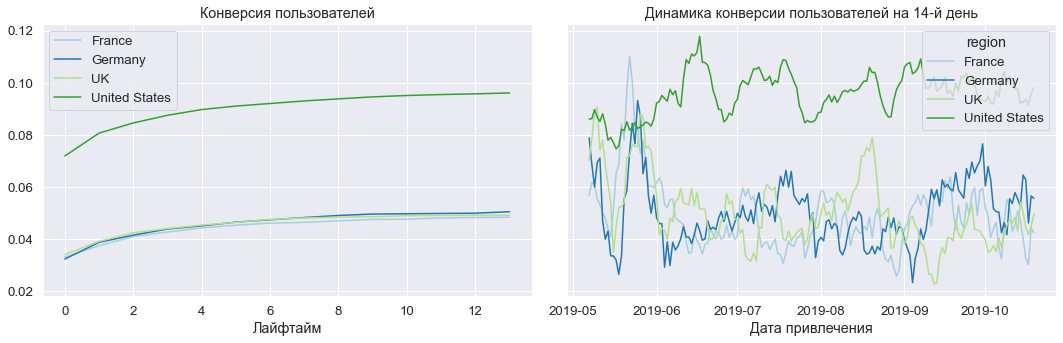

In [73]:
# смотрим конверсию с разбивкой по странам
dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    marketing_costs, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

<div style="border:solid lightgreen 2px; padding: 20px">
<div class="alert alert-block alert-info">
<font color='Black'>
    <ul><b>Выводы:</b>
Конверсии в США значительно превышают конверсии в прочих странах. Так же в США наблюдается сезонность.
    </ul>
</font>  
</div>    
</div>

Анализ удержания с разбивкой по странам

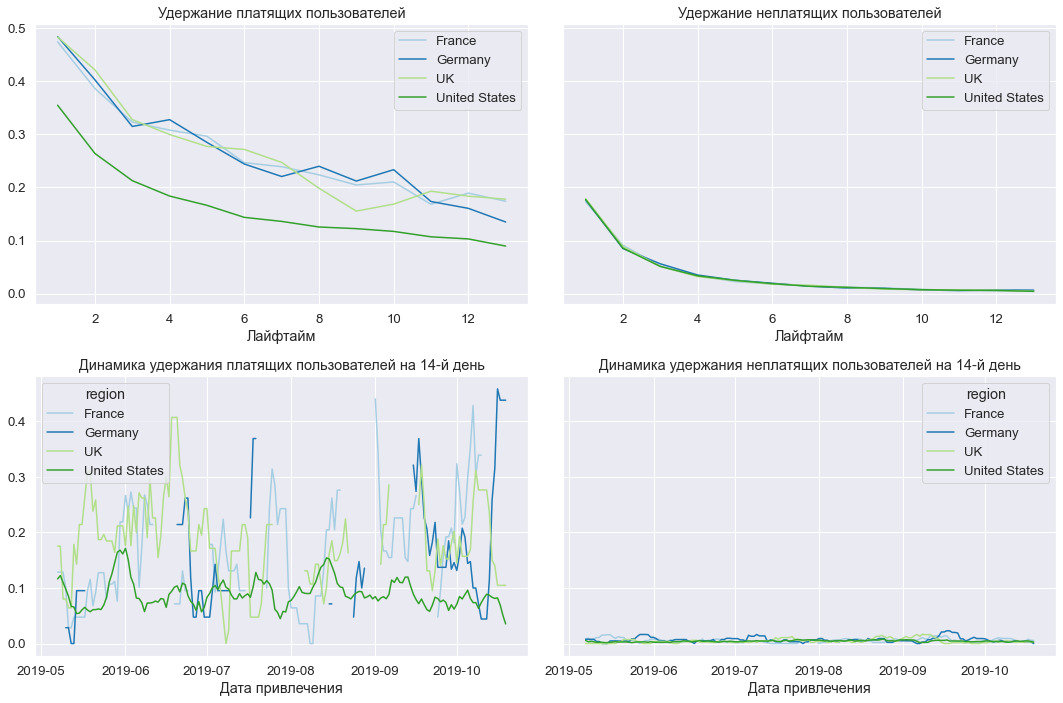

In [74]:
# смотрим удержание
dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    marketing_costs, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

<div style="border:solid lightgreen 2px; padding: 20px">
<div class="alert alert-block alert-info">
<font color='Black'>
    <ul><b>Выводы:</b>
Удержание платящих пользователей в США уступает удержанию в прочих странах, в то время как в других странах удержание находится приблизительно на одном уровне.
    </ul>
</font>  
</div>    
</div>

Анализ окупаемости рекламы с разбивкой по рекламным каналам

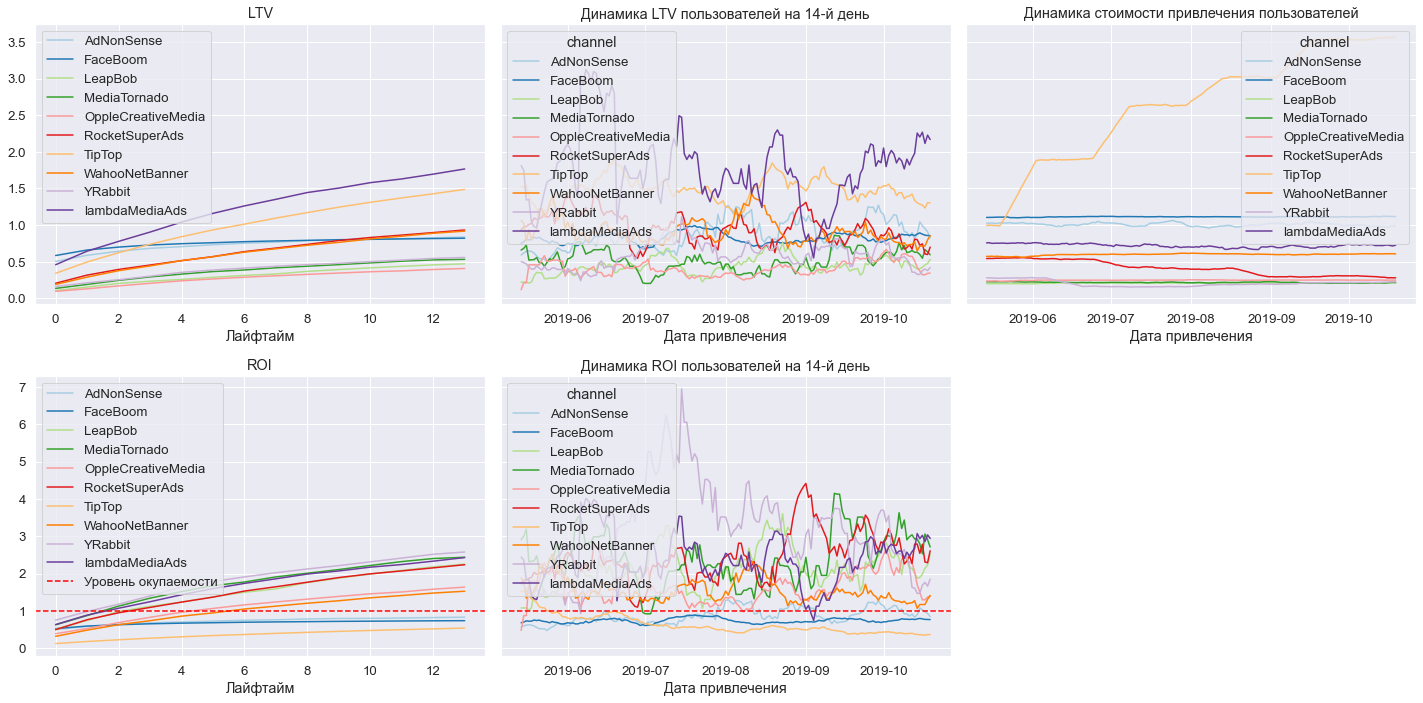

In [75]:
# смотрим окупаемость с разбивкой по каналам
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    marketing_costs, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

<div style="border:solid lightgreen 2px; padding: 20px">
<div class="alert alert-block alert-info">
<font color='Black'>
    <ul><b>Выводы:</b>
    <li>Самые дорогие в плане привлечения каналы (TipTop и FaceBoom) не окупаются.</li> 
    <li>Стоимость привлечения пользователей из канала TipTop крайне высока.</li>
    <li>Вызывает сомнения использование канала TipTop в будущем.</li>    
    </ul>
</font>  
</div>    
</div>

Анализ конверсии рекламы с разбивкой по каналам

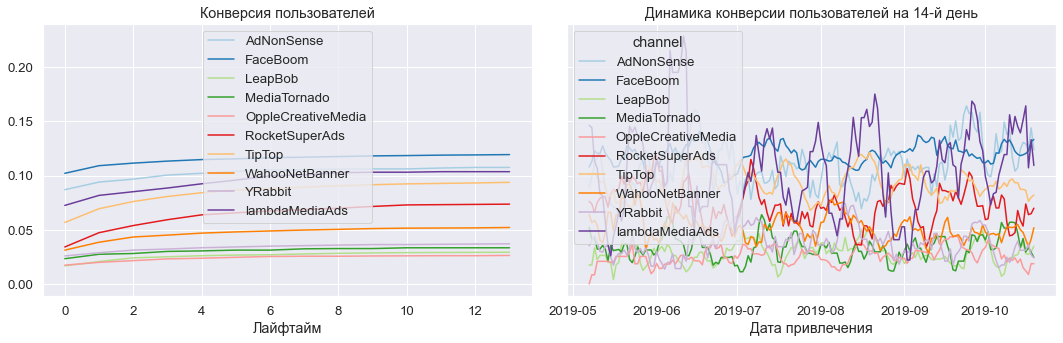

In [76]:
# смотрим конверсию
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    marketing_costs, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

<div style="border:solid lightgreen 2px; padding: 20px">
<div class="alert alert-block alert-info">
<font color='Black'>
    <ul><b>Выводы:</b>
Конверсии в разных каналах отличаются, но динамика практически отсутствует.
    </ul>
</font>  
</div>    
</div>

Анализ удержания с разбивкой по каналам

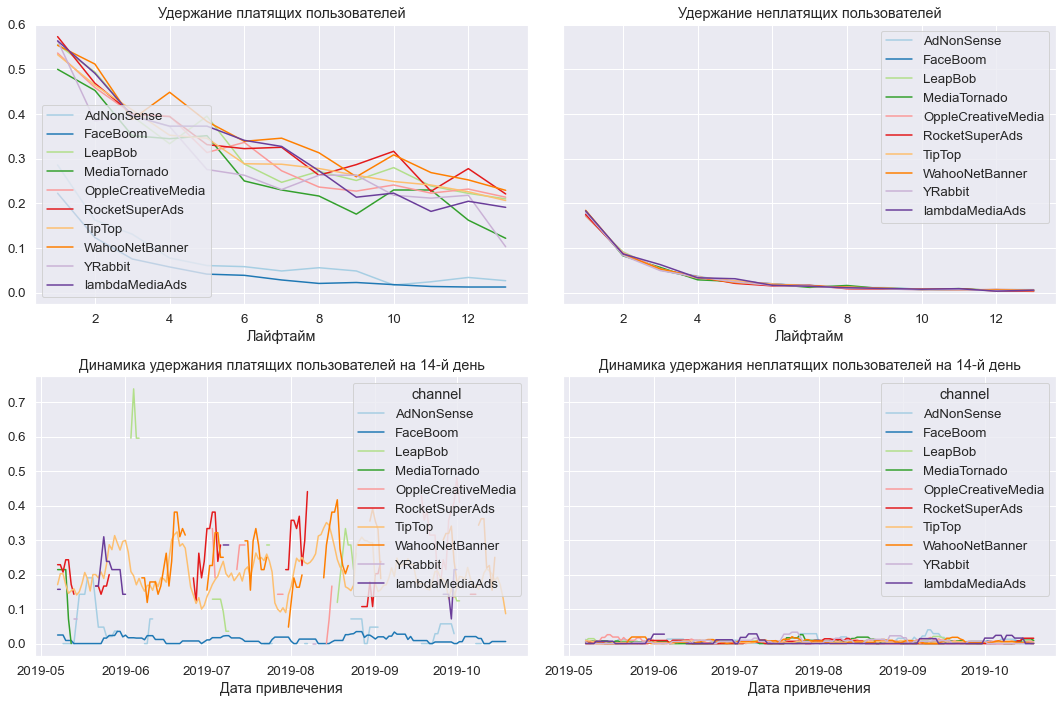

In [77]:
# смотрим удержание
dimensions = ['channel']

retention_raw, retention_grouped, retention_history = get_retention(
    marketing_costs, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

<div style="border:solid lightgreen 2px; padding: 20px">
<div class="alert alert-block alert-info">
<font color='Black'>
    <ul><b>Выводы:</b>
Удержание у в платящих пользователей в большинстве каналов на одном уровне, однако она сильно хуже у FaceBoom и AdNonSense.
    </ul>
</font>  
</div>    
</div>

<div class="alert alert-block alert-info">
<font color='Black'>
    <ul><b>Итог:</b>
    <li>Самые затратные каналы привлечения не окупаются.</li> 
    <li>Реклама в США не окупается .  
    <li>Реклама на всех устройствах, кроме PC не окупается .</li>
    <li>Требуется пересмотреть стратегию рекламного размещения, уменьшить бюджет на каналы TipTop и FaceBoom, провести исследования конкурентов на рынке США, возможно сервис либо уступает либо не пользуется необходимым спросом. Требуется анализ сервиса на мобильных устройствах либо скорректировать на них рекламу, так как сейчас окупаемость не достигнута.</li>    
    </ul>
</font>  
</div>    